# CS219: Physics Playground Data Analysis
Data Source: Ma. Mercedes Rodrigo (Accessed: April 5, 2017)


Importing Libraries

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import os
from datetime import timedelta

from scipy import stats

Working directories

In [2]:
wd = "data/"
stealth_data_dir = wd + "stealth.xlsx"
bromp_data_dir = wd + "bromp/"

## Data Preprocessing

### Stealth Dataset

* Loading dataset
* Mimic ms offset from start by cumulative sum
* Save dataframe

In [ ]:
df_stealth = pd.read_excel(stealth_data_dir)
df_stealth = df_stealth.sort_values(by=["id", "level"])

df_stealth.sort_values(by=["id", "start_time"], inplace=True)
df_stealth.reset_index(inplace=True, drop=True)
df_stealth["msoffsetfromstart"] = df_stealth.groupby(["id"])["time_spent"].cumsum()

df_stealth.to_csv(wd+"stealth.csv", index=False)

### Loading + Processing BROMP dataset

* Parse header details
* Collating BROMP dataset
* Format timestamps
* Saving dataframe

In [ ]:
header_key = np.array(['username', 'software', 'classname', 'numstudents', 'behavior', 'affect', 
                       'localtime', 'ntptime', 'ntptimestamp_ms', 'intervention'])
header_val = np.array([])
data_key = np.array(['studentid', 'msoffsetfromstart', 'behavior', 'affect', 'intervention'])

df_bromp = pd.DataFrame()

In [ ]:
for file in os.listdir(bromp_data_dir):
    with open(bromp_data_dir + file) as fp:
        for i, line in enumerate(fp):
            if i == 1:
                header_val = line.strip().split(",")
    dict_header = dict(zip(header_key, header_val))

    df = pd.read_csv(bromp_data_dir + file, names=data_key, skiprows=3)
    
    df["proctor"] = dict_header["username"]
    df["ts_begin"] = dict_header["ntptime"]
    
    df_bromp = df_bromp.append(df)

df_bromp["studentid"] = df_bromp["studentid"].apply(lambda x: x.lower())
df_bromp["ts_begin"] = pd.to_datetime(df_bromp["ts_begin"])
df_bromp["ts_obs"] = df_bromp["ts_begin"] + df_bromp["msoffsetfromstart"].apply(lambda x: timedelta(microseconds=1000*x))

df_bromp.sort_values(by=["studentid", "msoffsetfromstart"], inplace=True)
df_bromp.reset_index(inplace=True, drop=True)

df_bromp.to_csv(wd+"bromp.csv", index=False)

### Consolidating Stealth and BROMP data
* Went through stealth data per student id 
    * Get msoffsetfromstart
    * Go through stealth data rows
        * Matching each stealth row to the nearest BROMP row, in terms of msoffsetfromstart, with behavior and affect
    * Add as additional columns in stealth: behavior and affect
    


In [4]:
df_stealth = pd.read_csv(wd + "stealth.csv", index_col=False)
df_bromp = pd.read_csv(wd + "bromp.csv", index_col=False)

In [ ]:
def closest_offset(offset, df_with_offsets):
    offset_ix = df_with_offsets.index[0]
    offsets = np.asarray(df_with_offsets["msoffsetfromstart"])
    
    distances = (offsets - offset)**2
    ix_of_min = np.argmin(distances) + offset_ix
    return df_with_offsets.ix[ix_of_min]

Assigning nearest msoffset affects and behaviors to stealth rows from BROMP 

In [ ]:
df_stealth["behavior"] = -1
df_stealth["affect"] = -1

for cur_ix, stealth_row in df_stealth.iterrows():
    df = df_bromp[df_bromp["studentid"] == stealth_row["id"]]
    bromp_row = closest_offset(stealth_row["msoffsetfromstart"], df)
    df_stealth.ix[cur_ix, "behavior"] = bromp_row["behavior"]
    df_stealth.ix[cur_ix, "affect"] = bromp_row["affect"]
    

In [ ]:
df_stealth.to_csv(wd+"stealth.csv", index=False)


**FINDINGS**
- Time start and end in stealth/log dataset unknown start time
- Unproportional/unbalanced sampling sizes in both stealth and bromp datasets

## HYPOTHESIS 1 : Students get bored as their gameplay duration extends.

- Normalize msoffsetfrom by studentid -- this should make msoffsetfromstart ranges for all rows equal (0 to 1)
- Save boredom rating count per time ranges / bin 
- Plot results 
- Aggregate data for all users and assess changes over time

In [3]:
df_stealth = pd.read_csv(wd+"stealth.csv", index_col=False)

Normalize msoffsetfromstart

In [4]:
df_stealth["n_msoffsetfromstart"] = df_stealth.groupby("id")["msoffsetfromstart"].apply(lambda x: (x-min(x))/(max(x)-min(x)))

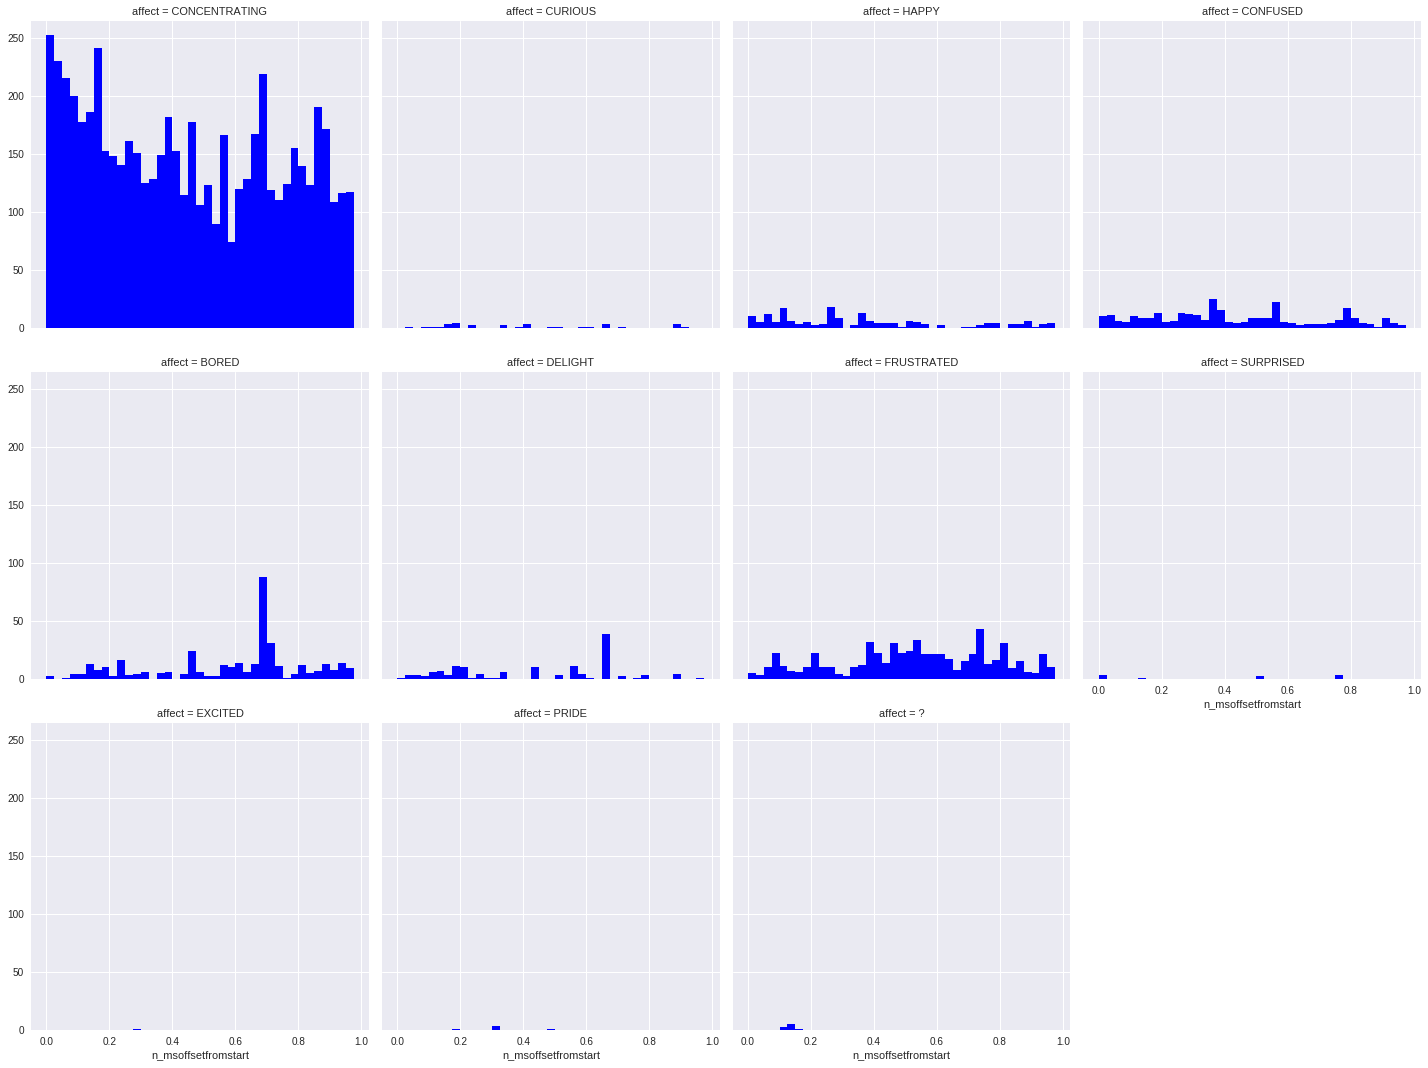

In [5]:
sns.set(font_scale=1)
bins = np.arange(0, 1, 0.025)
g = sns.FacetGrid(df_stealth, col="affect", col_wrap=4, size=5)
g = g.map(plt.hist, "n_msoffsetfromstart", bins=bins, color="b")

Box plots

In [6]:
df_stealth["school"] = df_stealth["id"].apply(lambda x: "UC" if "uc" in x else "BNHS")

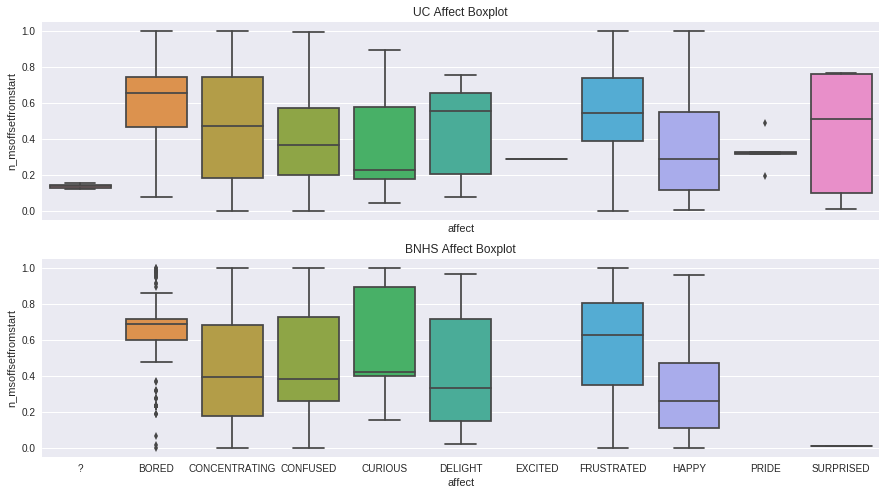

In [7]:
plt.rcParams['figure.figsize']=(15,8)

uc_data = df_stealth[df_stealth["school"] == "UC"]
bnhs_data = df_stealth[df_stealth["school"] == "BNHS"]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
order = sorted(df_stealth["affect"].unique())

sns.boxplot(x="affect", y="n_msoffsetfromstart", data=uc_data, ax=ax1, order=order)
ax1.set_title('UC Affect Boxplot')
sns.boxplot(x="affect", y="n_msoffsetfromstart", data=bnhs_data, ax=ax2, order=order)
ax2.set_title('BNHS Affect Boxplot')

In [8]:
df_with_affect_dummies = pd.get_dummies(df_stealth["affect"])
df_with_behavior_dummies = pd.get_dummies(df_stealth["behavior"])
df_with_dummies = pd.concat([df_stealth, df_with_affect_dummies], axis=1)
df_with_dummies = pd.concat([df_with_dummies, df_with_behavior_dummies], axis=1)

In [9]:
from pandas.tools.plotting import autocorrelation_plot
def plot_autocorr(df, idx, affect):
    df_autocorr = df.set_index("ts_obs")
    df_autocorr = df[["ts_obs", affect]]
    df_autocorr = df_autocorr.set_index(["ts_obs"])
    colors = ['#37AB65', '#3DF735', '#13AD45', '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#F6CC1D']
    autocorrelation_plot(df_autocorr[affect], label=affect, color=colors[idx])

An autocorrelation plot is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. (The prefix auto means “self”— autocorrelation specifically refers to correlation among the elements of a time series.)

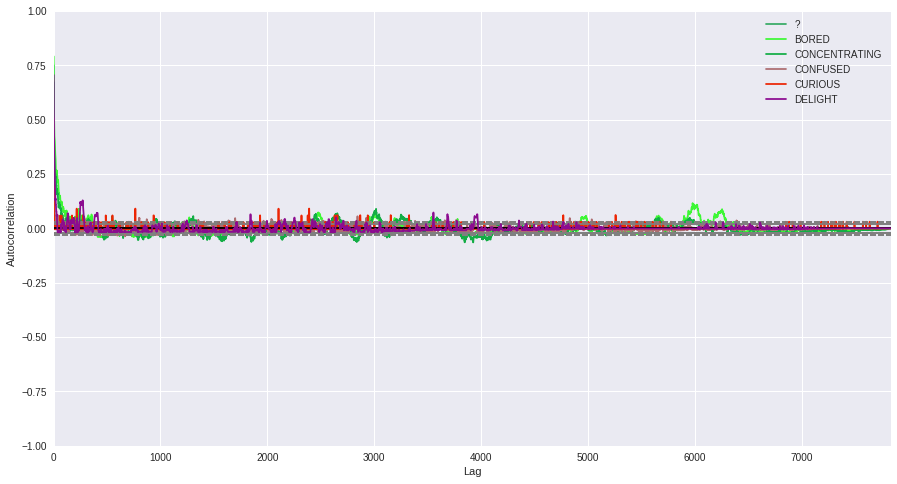

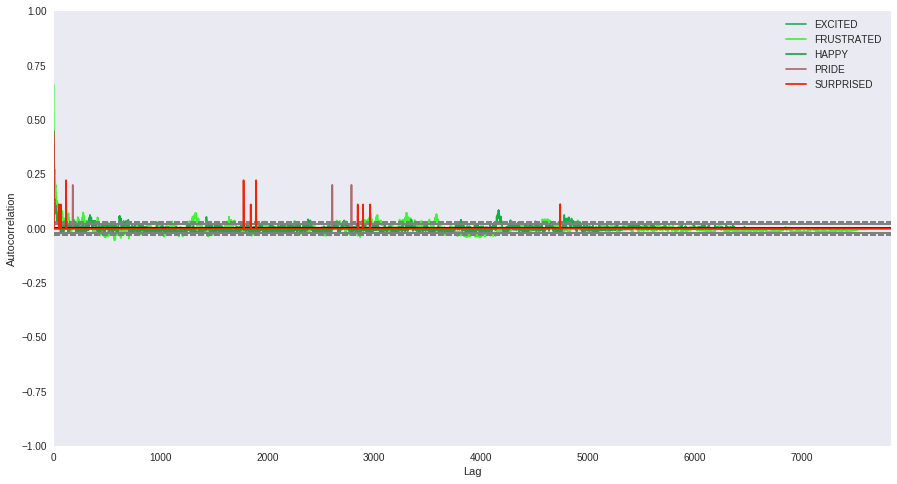

In [10]:
plt.rcParams['figure.figsize']=(15,8)
df_with_dummies["ts_obs"] = df_with_dummies["n_msoffsetfromstart"].apply(lambda x: timedelta(microseconds=1000*x))

for idx, val in enumerate(sorted(df_stealth["affect"].unique())[:6]):
    plot_autocorr(df_with_dummies, idx, val)
    plt.legend(loc='upper right')

plt.figure()

for idx, val in enumerate(sorted(df_stealth["affect"].unique())[6:]):
    plot_autocorr(df_with_dummies, idx, val)
    plt.legend(loc='upper right')

**FINDINGS**
- Answer to hypothesis: Boredom indeed increases as gameplay duration extends.
- Quality of analysis may be improved by using affect transition (what Miggy developed and Hadrian used) for a more exhaustive tally of affect states per stealth log observation.

**More insights**
- Affect distribution (from box plots)
    - Common observations
        - BORED: Late 
        - CONCENTRATING, DELIGHT: Early to Mid
        - CONFUSED, FRUSTRATED: Mid
        - HAPPY: Early
        - EXCITED, PRIDE: Small number of observations
    - School-dependent observations
        - CURIOUS: UC - early to mid, BNHS - mid to late
        - SURPRISED: UC - mid, BNHS-early
- Observable tendency of bored frequencies landing on around 0.75 of normalized ms offset
- Weak evidence of continuity in affective states

## HYPOTHESIS 2 : Bored students perform less than those who are less bored.

- Formulated achievement scoring measure per student per unit time: score = (1.5 * gold + silver) * difficulty / time 
- Differentiate bored and engaged students
    - Remove student having one or more BORED affect state
    - Setting a threshold when a student is BORED
- Compare bored and not bored students’ scores 

Achievement scoring considering time spent

In [11]:
df_stealth["score"] = df_stealth.apply(lambda x: x["difficulty_score"] * (1.5 * x["gold"] + x["silver"]) / 
                                      (x["time_spent"]), axis=1)

Function to plot bored vs not-bored data: When bored, student is bored

In [12]:
def comp_plot(df_bored, df_not_bored):
    plt.rcParams['figure.figsize']=(15,5)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.set_title("Bored Students")
    ax1.set_ylabel('Score')
    df_bored.groupby(["id"])["score"].sum().plot(kind="bar", ax=ax1)

    ax2.set_title("Not Bored Students")
    df_not_bored.groupby(["id"])["score"].sum().plot(kind="bar", ax=ax2)

In [13]:
def stats_test(bored_scores, not_bored_scores_unsampled):
    ttest_p = np.array([])
    levene_p = np.array([])

    n = 5

    for i in range(n):
        not_bored_scores = not_bored_scores_unsampled.sample(n=len(bored_scores))
        levene = stats.levene(bored_scores.values, not_bored_scores.values)
        levene_p = np.append(levene_p, levene[1])
        print("Run {}: Levene test [statistic: {}, pvalue: {}]".format(i, levene[0], levene[1]))
    print("Average Levene p-value: {}\n".format(levene_p.mean()))

    eq_var = False
    if levene_p.mean() >= 0.05:
        eq_var = True

    for i in range(n):
        not_bored_scores = not_bored_scores_unsampled.sample(n=len(bored_scores))
        ttest = stats.ttest_ind(bored_scores.values, not_bored_scores.values, equal_var = eq_var)
        ttest_p = np.append(ttest_p, ttest[1])
        print("Run {}: Independent t-test [statistic: {}, pvalue: {}]".format(i, ttest[0], ttest[1]))
    print("Average Independent t-test p-value: {}".format(ttest_p.mean()))


Separating bored from not bored students. As long as an affect of BORED is recorded, the student is BORED.

Run 0: Levene test [statistic: 6.278196237668329, pvalue: 0.015524492895229416]
Run 1: Levene test [statistic: 6.0006235272579245, pvalue: 0.017846625906078797]
Run 2: Levene test [statistic: 5.544890327367559, pvalue: 0.022501709419647544]
Run 3: Levene test [statistic: 5.071096226923044, pvalue: 0.028751491920837924]
Run 4: Levene test [statistic: 4.359783021488187, pvalue: 0.041911340117768675]
Average Levene p-value: 0.025307132051912474

Run 0: Independent t-test [statistic: 0.9475667280274801, pvalue: 0.3490281624385535]
Run 1: Independent t-test [statistic: 1.1869397231549534, pvalue: 0.2426975131844545]
Run 2: Independent t-test [statistic: 1.2372989700021393, pvalue: 0.22358954267330805]
Run 3: Independent t-test [statistic: 0.8884486114823189, pvalue: 0.3797097860236025]
Run 4: Independent t-test [statistic: 1.0179815676269734, pvalue: 0.31496617802508625]
Average Independent t-test p-value: 0.301998236469001


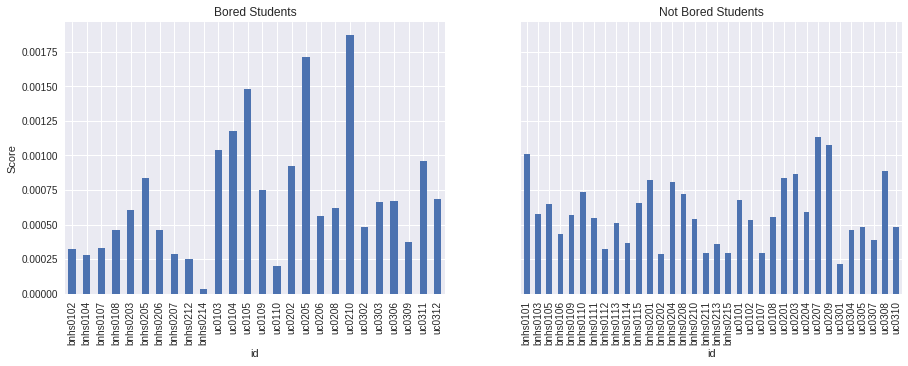

In [14]:
ids_with_bored = df_stealth[df_stealth["affect"]=="BORED"]["id"].unique()

df_stealth_bored = df_stealth[df_stealth["id"].isin(ids_with_bored)]
df_stealth_not_bored = df_stealth[-df_stealth["id"].isin(ids_with_bored)]

comp_plot(df_stealth_bored, df_stealth_not_bored)

bored_scores = df_stealth_bored.groupby(["id"])["score"].sum().reset_index()["score"]
not_bored_scores_unsampled = df_stealth_not_bored.groupby(["id"])["score"].sum().reset_index()["score"]


stats_test(bored_scores, not_bored_scores_unsampled)

Refining to more specific boredom threshold

In [15]:
df_affect_count = df_stealth.groupby(["id"])["affect"].value_counts()
df_affect_count = df_affect_count.to_frame()
df_affect_count = df_affect_count.add_suffix('_count').reset_index()

In [16]:
piv_affect_count = df_affect_count.pivot_table(index='id', columns='affect', values='affect_count')
piv_affect_count.reset_index(inplace=True)
piv_affect_count = piv_affect_count.fillna(0)

In [17]:
piv_affect_count["TOTAL"] = piv_affect_count.sum(axis=1, numeric_only=True)

In [18]:
df_percent_count = pd.DataFrame(columns=["percent", "count"])

for percent in np.linspace(0,1,51):
    count = piv_affect_count[piv_affect_count["BORED"] >= percent * piv_affect_count["TOTAL"]].shape[0]
    df = pd.DataFrame([[percent, count]], columns=["percent", "count"])
    df_percent_count = df_percent_count.append(df)

Number of bored students according to percent threshold of BORED affect in respect to all affect records / student

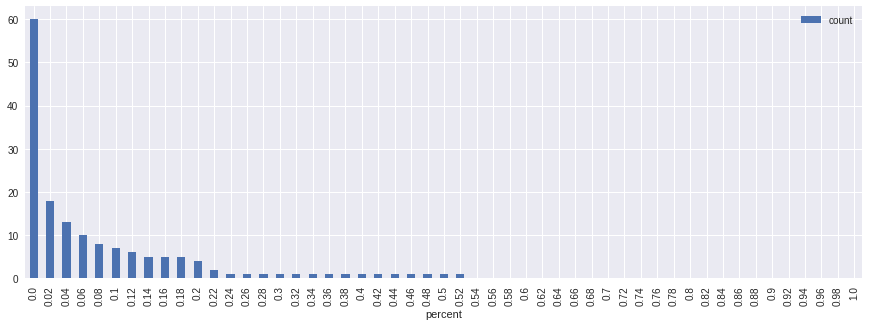

In [19]:
plt.rcParams['figure.figsize']=(15,5)
df_percent_count.plot(x="percent", y="count", kind='bar')

Picking threshold 0.2 (18 bored students and rest not bored)

In [20]:
id_atleast2percent_bored = piv_affect_count[piv_affect_count["BORED"] >= 0.02 * piv_affect_count["TOTAL"]]["id"].values

Run 0: Levene test [statistic: 0.7743415617624403, pvalue: 0.38505493578552297]
Run 1: Levene test [statistic: 0.00027064056645370653, pvalue: 0.9869706286778589]
Run 2: Levene test [statistic: 1.0218584215630908, pvalue: 0.31921879364905076]
Run 3: Levene test [statistic: 0.009411066760985548, pvalue: 0.9232875440808226]
Run 4: Levene test [statistic: 0.10006412155590223, pvalue: 0.7536866545425026]
Average Levene p-value: 0.6736437113471515

Run 0: Independent t-test [statistic: -1.7176753607557527, pvalue: 0.09495249380955272]
Run 1: Independent t-test [statistic: -1.3617869562901688, pvalue: 0.18222077247392063]
Run 2: Independent t-test [statistic: -1.6539041187572727, pvalue: 0.10735187519376806]
Run 3: Independent t-test [statistic: -1.273490055595043, pvalue: 0.21148206159698069]
Run 4: Independent t-test [statistic: -1.5083171257649919, pvalue: 0.14071045714465938]
Average Independent t-test p-value: 0.1473435320437763


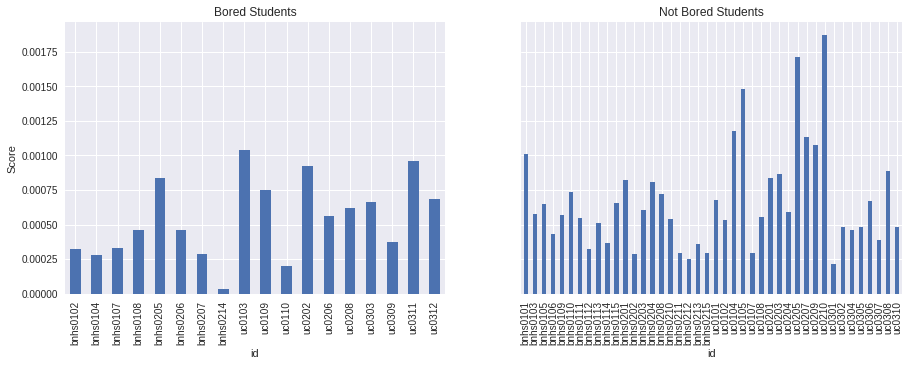

In [21]:
df_threshold_bored = df_stealth[df_stealth["id"].isin(id_atleast2percent_bored)]
df_threshold_not_bored = df_stealth[-df_stealth["id"].isin(id_atleast2percent_bored)]

comp_plot(df_threshold_bored, df_threshold_not_bored)

bored_scores = df_threshold_bored.groupby(["id"])["score"].sum().reset_index()["score"]
not_bored_scores_unsampled = df_threshold_not_bored.groupby(["id"])["score"].sum().reset_index()["score"]

stats_test(bored_scores, not_bored_scores_unsampled)

**FINDINGS**
- Null hypothesis: There is no significant difference between the scores of bored and not bored students
- First experiment (students with at least single instance of BORED affect is bored) yielded average ttest score of 0.30. On the otherhand, second experiment (students who were bored at least 2% of the time) yielded average ttest score of 0.15.
- Both 2 sample t-test resulted to a p-value of > 0.05, hence the null hypothesis is accepted
- Hence: **There is no significant difference between the performances of bored and not bored students**
- Quality of analysis: Quality may be improved by increasing stealth observations thereby increasing bored students.

**Further insights**
- Acceptable due to low threshold set
- Decrease in p-value (closer to rejection of null hypothesis) when students were better filtered out.

## HYPOTHESIS 3 : Bored students tend to draw more objects or stack during the game.

- Aggregate object count drawn of bored students and unbored students
- Aggregate instances of stacking for bored and unbored students
- Compare results from the two points above




In [22]:
df_stealth["behavior"].value_counts()

ON TASK      7503
WTF           111
STACKING$      92
OFF TASK       73
OTHER$         47
?               8
Name: behavior, dtype: int64

In [24]:
df_stealth[df_stealth["behavior"] == "STACKING$"]["affect"].value_counts()

CONCENTRATING    33
FRUSTRATED       28
BORED            20
HAPPY             6
CONFUSED          5
Name: affect, dtype: int64

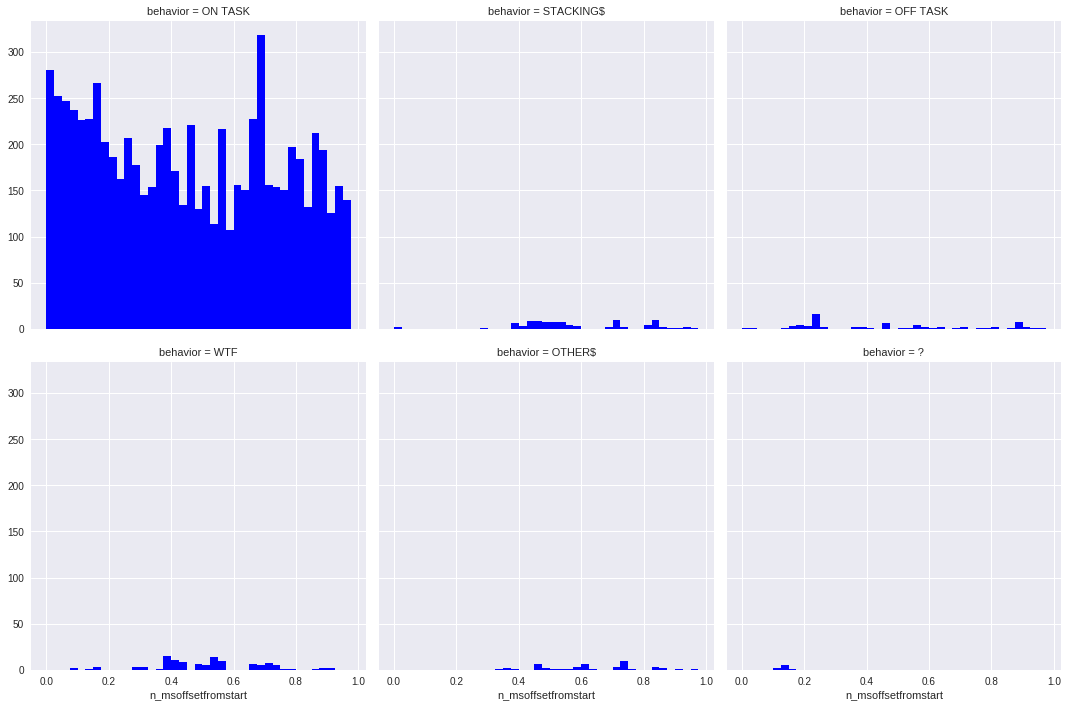

In [25]:
sns.set(font_scale=1)
bins = np.arange(0, 1, 0.025)
g = sns.FacetGrid(df_stealth, col="behavior", col_wrap=3, size=5)
g = g.map(plt.hist, "n_msoffsetfromstart", bins=bins, color="b")

Correlation between BORED dummy column (binary) with object count (discrete): Application of **point biserial correlation**

In [26]:
stats.pointbiserialr(x=df_with_dummies["BORED"].values, y=df_with_dummies["obj_count"].values)

PointbiserialrResult(correlation=-0.012957107078298689, pvalue=0.25150678606576954)

Correlation between BORED dummy column (binary) with stacking dummy column (binary). Application of **phi correlation**

In [27]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(df_with_dummies["BORED"].values, df_with_dummies["STACKING$"])

0.08367516131732762

In [28]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing

In [29]:
features = ["attempt", "obj_count", "time_spent", "event", "difficulty_score", "badge", "no_revisits",
                "no_restarts", "behavior"]
data = df_with_dummies[features].apply(preprocessing.LabelEncoder().fit_transform)

target = df_with_dummies["BORED"]

Feature ranking:
1. feature difficulty_score (0.248699)
2. feature no_restarts (0.191873)
3. feature time_spent (0.171610)
4. feature behavior (0.140243)
5. feature attempt (0.102769)
6. feature obj_count (0.096487)
7. feature no_revisits (0.018987)
8. feature event (0.018017)
9. feature badge (0.011314)


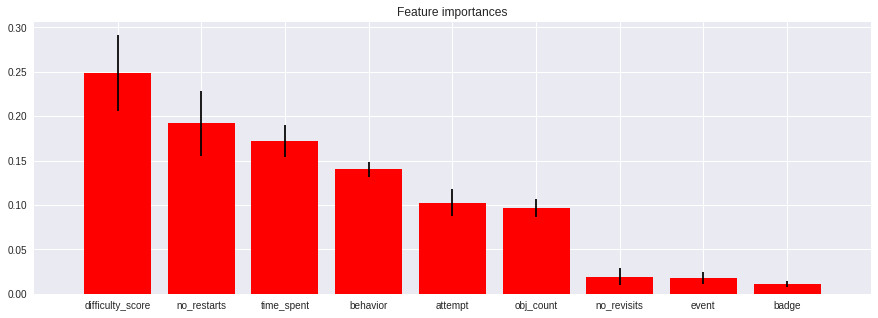

In [31]:
model = ExtraTreesClassifier()
model.fit(data.as_matrix(), target.as_matrix())

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(data.as_matrix().shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
plt.rcParams['figure.figsize']=(15,5)
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.as_matrix().shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.as_matrix().shape[1]), [features[idx] for idx in indices])
plt.xlim([-1, data.as_matrix().shape[1]])
plt.show()

Least contribution: event, badge, no. of revisits

**FINDINGS**
- Low correlation scores for both (a) BORED observations and stacking, and (b) BORED observations and object drawn
- Investigated important features using ExtraTreesClassifier, showed top three features that can be attributed to boredom might be difficulty score, no_restarts, time_spent.

## SUPPLEMENTAL VIS

Histogram plot of total number of attempts per student

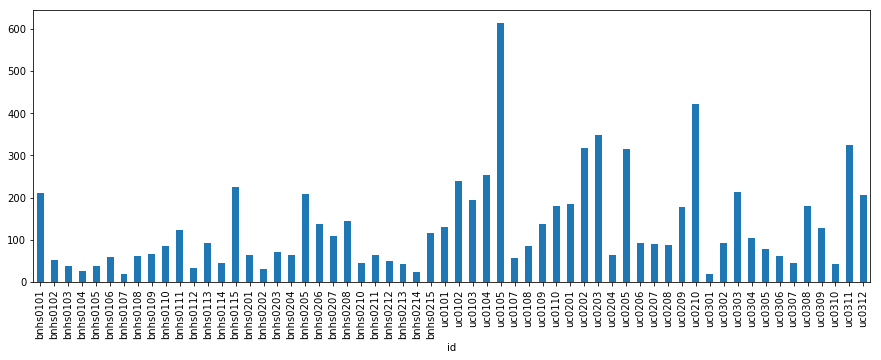

In [44]:
df.groupby(["id"]).size().plot(kind="bar", figsize=(15,5))

Histogram plot of total timespent per student

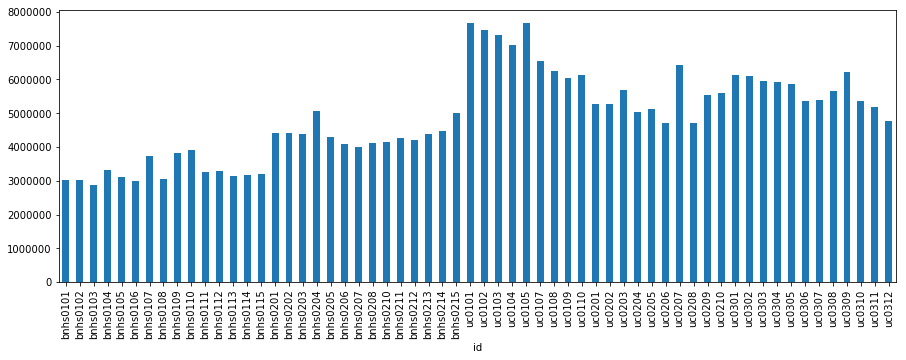

In [45]:
df.groupby("id")["time_spent"].sum().plot(kind="bar", figsize=(15,5))